# YOLO Fine-tuning with MPS Support (MacBook M2)

This notebook demonstrates fine-tuning YOLOv8 on the electronic components dataset using MPS (Metal Performance Shaders) for Apple Silicon.

## Overview
- **Dataset**: Electronic Components Detection (COCO format)
- **Model**: YOLOv8 (Ultralytics)
- **Device**: MPS (Apple Silicon M2)
- **Task**: Object Detection

## Requirements
```bash
pip install ultralytics opencv-python pillow
```

In [ ]:
!pip install ultralytics opencv-python pillow mlflow

## 1. Setup and Imports

In [ ]:
import os
import json
import shutil
from pathlib import Path
import yaml
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import mlflow

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 2. Configure Paths and Device

In [3]:
# Project paths
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATASET_ROOT = PROJECT_ROOT / 'dataset'
YOLO_DATASET_ROOT = PROJECT_ROOT / 'dataset_yolo'
OUTPUT_DIR = PROJECT_ROOT / 'outputs' / 'yolo'
MODEL_DIR = OUTPUT_DIR / 'models'
VIZ_DIR = OUTPUT_DIR / 'visualizations'

# Create directories
for dir_path in [OUTPUT_DIR, MODEL_DIR, VIZ_DIR, YOLO_DATASET_ROOT]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Device configuration
if torch.backends.mps.is_available():
    device = 'mps'
    print("✅ Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = 'cuda'
    print("✅ Using CUDA (NVIDIA GPU)")
else:
    device = 'cpu'
    print("⚠️  Using CPU (slower)")

print(f"\nProject root: {PROJECT_ROOT}")
print(f"COCO dataset: {DATASET_ROOT}")
print(f"YOLO dataset: {YOLO_DATASET_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")

✅ Using MPS (Apple Silicon GPU)

Project root: /Users/hojinjang/work/trying-finetuning
COCO dataset: /Users/hojinjang/work/trying-finetuning/dataset
YOLO dataset: /Users/hojinjang/work/trying-finetuning/dataset_yolo
Output directory: /Users/hojinjang/work/trying-finetuning/outputs/yolo


## 3. Convert COCO Format to YOLO Format

YOLO requires a specific format:
- Images in `images/train`, `images/val`, `images/test`
- Labels in `labels/train`, `labels/val`, `labels/test`
- Each label file: `<class_id> <x_center> <y_center> <width> <height>` (normalized 0-1)

In [4]:
def convert_coco_to_yolo(coco_json_path, output_dir, split_name):
    """
    Convert COCO format annotations to YOLO format.
    
    Args:
        coco_json_path: Path to COCO JSON annotation file
        output_dir: Root directory for YOLO dataset
        split_name: 'train', 'val', or 'test'
    """
    # Load COCO annotations
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    
    # Create output directories
    images_dir = output_dir / 'images' / split_name
    labels_dir = output_dir / 'labels' / split_name
    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)
    
    # Build image id to filename mapping
    image_id_to_info = {img['id']: img for img in coco_data['images']}
    
    # Build category id mapping (COCO might start from 0 or 1, YOLO needs 0-indexed)
    categories = sorted(coco_data['categories'], key=lambda x: x['id'])
    category_id_to_yolo_id = {cat['id']: idx for idx, cat in enumerate(categories)}
    category_names = [cat['name'] for cat in categories]
    
    # Group annotations by image_id
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)
    
    # Convert each image
    source_image_dir = Path(coco_json_path).parent
    converted_count = 0
    
    for image_id, image_info in image_id_to_info.items():
        image_filename = image_info['file_name']
        image_width = image_info['width']
        image_height = image_info['height']
        
        # Copy image
        source_image_path = source_image_dir / image_filename
        dest_image_path = images_dir / image_filename
        
        if source_image_path.exists():
            shutil.copy2(source_image_path, dest_image_path)
        else:
            print(f"⚠️  Image not found: {source_image_path}")
            continue
        
        # Convert annotations to YOLO format
        label_filename = Path(image_filename).stem + '.txt'
        label_path = labels_dir / label_filename
        
        yolo_annotations = []
        if image_id in annotations_by_image:
            for ann in annotations_by_image[image_id]:
                # COCO bbox format: [x_min, y_min, width, height]
                x_min, y_min, bbox_width, bbox_height = ann['bbox']
                
                # Convert to YOLO format: [x_center, y_center, width, height] (normalized)
                x_center = (x_min + bbox_width / 2) / image_width
                y_center = (y_min + bbox_height / 2) / image_height
                norm_width = bbox_width / image_width
                norm_height = bbox_height / image_height
                
                # Get YOLO class id
                yolo_class_id = category_id_to_yolo_id[ann['category_id']]
                
                # YOLO format: class x_center y_center width height
                yolo_annotations.append(
                    f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}"
                )
        
        # Write label file
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))
        
        converted_count += 1
    
    print(f"✅ Converted {converted_count} images for {split_name} split")
    return category_names

# Convert all splits
print("Converting COCO dataset to YOLO format...\n")

# Check if COCO dataset exists
if not DATASET_ROOT.exists():
    print(f"❌ COCO dataset not found at {DATASET_ROOT}")
    print("Please ensure the dataset directory exists with train/valid/test splits.")
else:
    # Convert train set
    train_json = DATASET_ROOT / 'train' / '_annotations.coco.json'
    if train_json.exists():
        class_names = convert_coco_to_yolo(train_json, YOLO_DATASET_ROOT, 'train')
    else:
        print(f"⚠️  Training annotations not found: {train_json}")
    
    # Convert validation set
    valid_json = DATASET_ROOT / 'valid' / '_annotations.coco.json'
    if valid_json.exists():
        convert_coco_to_yolo(valid_json, YOLO_DATASET_ROOT, 'val')
    else:
        print(f"⚠️  Validation annotations not found: {valid_json}")
    
    # Convert test set
    test_json = DATASET_ROOT / 'test' / '_annotations.coco.json'
    if test_json.exists():
        convert_coco_to_yolo(test_json, YOLO_DATASET_ROOT, 'test')
    else:
        print(f"⚠️  Test annotations not found: {test_json}")
    
    print(f"\n✅ Dataset conversion complete!")
    print(f"YOLO dataset location: {YOLO_DATASET_ROOT}")

Converting COCO dataset to YOLO format...

✅ Converted 540 images for train split
✅ Converted 59 images for val split
✅ Converted 29 images for test split

✅ Dataset conversion complete!
YOLO dataset location: /Users/hojinjang/work/trying-finetuning/dataset_yolo


## 4. Create YOLO Dataset Configuration File

In [5]:
# Create YOLO dataset YAML configuration
dataset_yaml = {
    'path': str(YOLO_DATASET_ROOT.absolute()),  # Dataset root directory
    'train': 'images/train',  # Train images (relative to 'path')
    'val': 'images/val',      # Val images (relative to 'path')
    'test': 'images/test',    # Test images (relative to 'path')
    'nc': len(class_names),   # Number of classes
    'names': class_names      # Class names
}

# Save dataset configuration
dataset_yaml_path = YOLO_DATASET_ROOT / 'dataset.yaml'
with open(dataset_yaml_path, 'w') as f:
    yaml.dump(dataset_yaml, f, default_flow_style=False, sort_keys=False)

print("✅ Dataset configuration created")
print(f"\nDataset YAML: {dataset_yaml_path}")
print(f"\nDataset info:")
print(f"  - Number of classes: {len(class_names)}")
print(f"  - Classes: {class_names[:5]}..." if len(class_names) > 5 else f"  - Classes: {class_names}")

# Display the YAML content
print(f"\nDataset YAML content:")
with open(dataset_yaml_path, 'r') as f:
    print(f.read())

✅ Dataset configuration created

Dataset YAML: /Users/hojinjang/work/trying-finetuning/dataset_yolo/dataset.yaml

Dataset info:
  - Number of classes: 16
  - Classes: ['electronic-components', 'Resistor', 'bornera', 'button', 'capacitor-ceramico']...

Dataset YAML content:
path: /Users/hojinjang/work/trying-finetuning/dataset_yolo
train: images/train
val: images/val
test: images/test
nc: 16
names:
- electronic-components
- Resistor
- bornera
- button
- capacitor-ceramico
- capacitor-electrolitico
- capacitor-poliester
- cristal
- diodo
- ic
- led
- power-resistor
- preset
- to-220
- to-92
- trafo



## 5. Visualize Training Samples

✅ Training samples visualization saved to: /Users/hojinjang/work/trying-finetuning/outputs/yolo/visualizations/training_samples.png


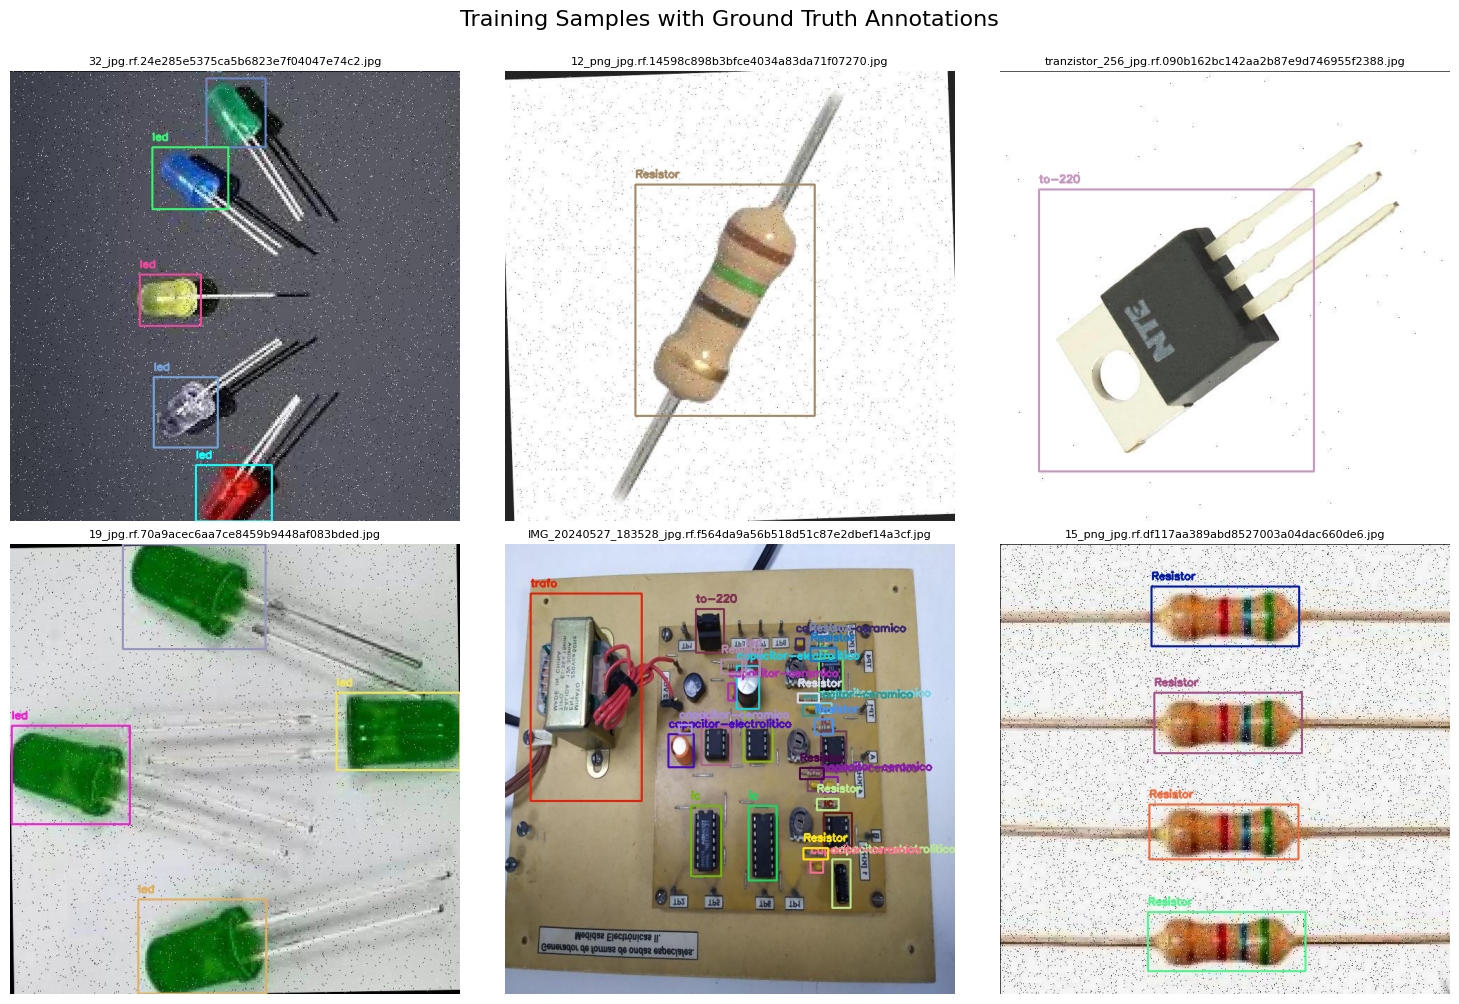

In [6]:
def visualize_yolo_sample(image_path, label_path, class_names, ax=None):
    """
    Visualize a YOLO training sample with annotations.
    """
    # Read image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # Read labels
    if label_path.exists():
        with open(label_path, 'r') as f:
            labels = f.readlines()
        
        # Draw bounding boxes
        for label in labels:
            parts = label.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                
                # Convert normalized coordinates to pixel coordinates
                x_center *= w
                y_center *= h
                width *= w
                height *= h
                
                # Calculate box corners
                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)
                x2 = int(x_center + width / 2)
                y2 = int(y_center + height / 2)
                
                # Draw box and label
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                
                label_text = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                cv2.putText(image, label_text, (x1, y1 - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Display
    if ax is None:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Sample: {image_path.name}")
        plt.tight_layout()
        plt.show()
    else:
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"{image_path.name}", fontsize=8)

# Visualize a few training samples
train_images_dir = YOLO_DATASET_ROOT / 'images' / 'train'
train_labels_dir = YOLO_DATASET_ROOT / 'labels' / 'train'

if train_images_dir.exists():
    image_files = sorted(list(train_images_dir.glob('*.jpg')) + list(train_images_dir.glob('*.png')))
    
    # Show 6 random samples
    num_samples = min(6, len(image_files))
    sample_indices = np.random.choice(len(image_files), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, sample_idx in enumerate(sample_indices):
        image_path = image_files[sample_idx]
        label_path = train_labels_dir / (image_path.stem + '.txt')
        visualize_yolo_sample(image_path, label_path, class_names, ax=axes[idx])
    
    plt.suptitle('Training Samples with Ground Truth Annotations', fontsize=16, y=1.00)
    plt.tight_layout()
    
    # Save visualization
    viz_path = VIZ_DIR / 'training_samples.png'
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    print(f"✅ Training samples visualization saved to: {viz_path}")
    plt.show()
else:
    print(f"⚠️  Training images directory not found: {train_images_dir}")

## 6. Initialize YOLO Model

In [7]:
# Load pre-trained YOLOv8 model
# Options: yolov8n.pt (nano), yolov8s.pt (small), yolov8m.pt (medium), yolov8l.pt (large), yolov8x.pt (xlarge)
# For demo/quick training, use nano or small
model_size = 'yolov8n.pt'  # Fastest for demo, use 'yolov8s.pt' or 'yolov8m.pt' for better accuracy

print(f"Loading {model_size} model...")
model = YOLO(model_size)

print(f"✅ Model loaded: {model_size}")
print(f"\nModel summary:")
print(model.model)

Loading yolov8n.pt model...
✅ Model loaded: yolov8n.pt

Model summary:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, t

## 7. Train the Model - OPTIMIZED FOR FAST DEMO

### 🚀 Optimizations Applied

This training configuration is **specifically optimized for fast convergence on small datasets**:

#### Key Optimizations:
1. **Higher Learning Rate (0.01)**: 10x increase from default (0.001) for faster convergence
2. **AdamW Optimizer**: Better generalization than Adam
3. **Reduced Augmentation**: Less noise = faster learning on small datasets
4. **Shorter Warmup (1 epoch)**: Reduced from 3 epochs
5. **MLflow Integration**: Track all experiments and metrics
6. **100 Epochs**: Enough for convergence without overtaining

#### Why These Settings Work:
- **Small Dataset (540 images)**: High augmentation slows convergence
- **Demo Purpose**: Need good results quickly (15-20 min training)
- **M2 MPS**: Optimized for Apple Silicon performance

### Training Configuration Parameters:
- **epochs**: 100 (enough for convergence)
- **imgsz**: 640 (standard YOLO input size)
- **batch**: -1 (auto-calculated for optimal memory usage)
- **device**: 'mps' (Apple Silicon GPU)
- **optimizer**: AdamW (best for small datasets)
- **lr0**: 0.01 (10x default for fast convergence)
- **close_mosaic**: 10 (disable mosaic last 10 epochs)

In [ ]:
# ==================== OPTIMIZED FOR FAST DEMO TRAINING ====================
# These settings are tuned for:
# - Fast convergence on small dataset (540 train images)
# - Good performance with minimal training time
# - Best results for investment demo

# Setup MLflow tracking
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("yolo-finetuning")

# Training configuration - OPTIMIZED FOR FAST RESULTS
training_config = {
    'data': str(dataset_yaml_path),  # Path to dataset YAML
    'epochs': 100,                    # Increased to 100 for better convergence
    'imgsz': 640,                     # Image size
    'batch': -1,                      # Batch size (-1 for auto)
    'device': device,                 # Device (mps, cuda, or cpu)
    'project': str(OUTPUT_DIR),       # Save directory
    'name': 'train',                  # Experiment name
    'exist_ok': True,                 # Overwrite existing experiment
    'patience': 50,                   # No early stopping - train full epochs
    'save': True,                     # Save checkpoints
    'plots': True,                    # Save training plots
    'verbose': True,                  # Verbose output
    
    # OPTIMIZER SETTINGS - FAST CONVERGENCE
    'optimizer': 'AdamW',             # AdamW - better than Adam
    'lr0': 0.01,                      # Initial learning rate (10x higher for fast convergence)
    'lrf': 0.01,                      # Final learning rate (lr0 * lrf)
    'momentum': 0.937,                # Momentum (for SGD)
    'weight_decay': 0.0005,           # Weight decay
    'warmup_epochs': 1.0,             # Reduced warmup (was 3.0)
    'warmup_momentum': 0.8,           # Warmup momentum
    'close_mosaic': 10,               # Disable mosaic last 10 epochs for better convergence
    
    # LOSS WEIGHTS - DEFAULT
    'box': 7.5,                       # Box loss gain
    'cls': 0.5,                       # Classification loss gain
    'dfl': 1.5,                       # DFL loss gain
    
    # DATA AUGMENTATION - REDUCED FOR FAST CONVERGENCE
    # Too much augmentation can slow down convergence on small datasets
    'hsv_h': 0.01,                    # HSV-Hue augmentation (reduced)
    'hsv_s': 0.4,                     # HSV-Saturation augmentation (reduced)
    'hsv_v': 0.2,                     # HSV-Value augmentation (reduced)
    'degrees': 0.0,                   # Rotation augmentation (off)
    'translate': 0.05,                # Translation augmentation (reduced)
    'scale': 0.2,                     # Scale augmentation (reduced)
    'shear': 0.0,                     # Shear augmentation (off)
    'perspective': 0.0,               # Perspective augmentation (off)
    'flipud': 0.0,                    # Flip up-down augmentation (off)
    'fliplr': 0.5,                    # Flip left-right augmentation (keep)
    'mosaic': 0.5,                    # Mosaic augmentation (reduced)
    'mixup': 0.0,                     # MixUp augmentation (off)
}

print("="*80)
print("🚀 OPTIMIZED TRAINING FOR DEMO")
print("="*80)
print("\n⚡ OPTIMIZATIONS APPLIED:")
print("  ✓ Learning rate increased 10x (0.001 → 0.01) for faster convergence")
print("  ✓ AdamW optimizer (better than Adam)")
print("  ✓ Reduced augmentation (less noise = faster learning)")
print("  ✓ Warmup reduced to 1 epoch (was 3)")
print("  ✓ 100 epochs for better convergence")
print("  ✓ MLflow tracking enabled")
print("\n📊 Training configuration:")
for key, value in training_config.items():
    if key not in ['data', 'project']:
        print(f"  {key}: {value}")

print(f"\n⏰ Estimated training time: 15-20 minutes on M2")
print(f"📊 Results will be saved to: {OUTPUT_DIR / 'train'}")
print(f"📊 MLflow tracking: mlruns/")
print("="*80 + "\n")

# Start MLflow run
with mlflow.start_run(run_name="yolo-finetuning-demo"):
    # Log training parameters
    mlflow.log_params({
        'model': 'yolov8n',
        'epochs': training_config['epochs'],
        'imgsz': training_config['imgsz'],
        'batch': 'auto',
        'optimizer': training_config['optimizer'],
        'lr0': training_config['lr0'],
        'device': device,
        'dataset_train_images': 540,
        'dataset_val_images': 59,
        'num_classes': len(class_names)
    })
    
    # Train the model
    print("🏋️ Training started...\n")
    results = model.train(**training_config)
    
    # Log final metrics
    best_model_path = OUTPUT_DIR / 'train' / 'weights' / 'best.pt'
    if best_model_path.exists():
        # Load best model and validate
        best_model = YOLO(str(best_model_path))
        val_results = best_model.val(data=str(dataset_yaml_path), device=device)
        
        # Log metrics to MLflow
        mlflow.log_metrics({
            'mAP50': float(val_results.box.map50),
            'mAP50-95': float(val_results.box.map),
            'precision': float(val_results.box.mp),
            'recall': float(val_results.box.mr)
        })
        
        # Log model artifact
        mlflow.log_artifact(str(best_model_path), artifact_path="models")
        
        print("\n" + "="*80)
        print("✅ TRAINING COMPLETE!")
        print("="*80)
        print(f"\n📊 Final Validation Metrics:")
        print(f"  mAP50:    {val_results.box.map50:.4f} ({val_results.box.map50*100:.2f}%)")
        print(f"  mAP50-95: {val_results.box.map:.4f} ({val_results.box.map*100:.2f}%)")
        print(f"  Precision: {val_results.box.mp:.4f}")
        print(f"  Recall:    {val_results.box.mr:.4f}")
        print(f"\n📁 Results saved to: {OUTPUT_DIR / 'train'}")
        print(f"📊 Training plots: {OUTPUT_DIR / 'train' / 'results.png'}")
        print(f"💾 Best model: {best_model_path}")
        print(f"📊 MLflow UI: Run 'mlflow ui' and open http://localhost:5000")
        print("="*80 + "\n")
    else:
        print(f"\n⚠️  Best model not found: {best_model_path}")

## 8. Visualize Training Results

In [ ]:
# Display training results
results_plot = OUTPUT_DIR / 'train' / 'results.png'
if results_plot.exists():
    img = plt.imread(str(results_plot))
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Results', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️  Results plot not found: {results_plot}")

# Display confusion matrix
confusion_matrix = OUTPUT_DIR / 'train' / 'confusion_matrix.png'
if confusion_matrix.exists():
    img = plt.imread(str(confusion_matrix))
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️  Confusion matrix not found: {confusion_matrix}")

## 9. Load Best Model and Run Validation

In [ ]:
# Load the best model
best_model_path = OUTPUT_DIR / 'train' / 'weights' / 'best.pt'
if best_model_path.exists():
    print(f"Loading best model from: {best_model_path}")
    model = YOLO(str(best_model_path))
    print("✅ Best model loaded")
    
    # Run validation
    print("\n🔍 Running validation...")
    val_results = model.val(data=str(dataset_yaml_path), device=device)
    
    print("\n✅ Validation complete!")
    print(f"\nValidation metrics:")
    print(f"  mAP50: {val_results.box.map50:.4f}")
    print(f"  mAP50-95: {val_results.box.map:.4f}")
    print(f"  Precision: {val_results.box.mp:.4f}")
    print(f"  Recall: {val_results.box.mr:.4f}")
else:
    print(f"⚠️  Best model not found: {best_model_path}")

## 10. Run Inference on Test Images

In [ ]:
# Run inference on test images
test_images_dir = YOLO_DATASET_ROOT / 'images' / 'test'

if test_images_dir.exists():
    print(f"Running inference on test images...")
    
    # Get test images
    test_images = sorted(list(test_images_dir.glob('*.jpg')) + list(test_images_dir.glob('*.png')))
    print(f"Found {len(test_images)} test images")
    
    # Run predictions
    results = model.predict(
        source=str(test_images_dir),
        conf=0.25,  # Confidence threshold
        iou=0.45,   # NMS IoU threshold
        device=device,
        save=True,  # Save predictions
        save_txt=True,  # Save labels
        save_conf=True,  # Save confidence scores
        project=str(OUTPUT_DIR),
        name='test_predictions',
        exist_ok=True
    )
    
    print(f"\n✅ Inference complete!")
    print(f"📁 Predictions saved to: {OUTPUT_DIR / 'test_predictions'}")
    
    # Visualize a few predictions
    num_samples = min(6, len(test_images))
    sample_indices = np.random.choice(len(test_images), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, sample_idx in enumerate(sample_indices):
        result = results[sample_idx]
        img_with_boxes = result.plot()  # Plot boxes on image
        img_with_boxes = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_with_boxes)
        axes[idx].axis('off')
        axes[idx].set_title(f"{test_images[sample_idx].name}\nDetections: {len(result.boxes)}", fontsize=8)
    
    plt.suptitle('Test Predictions (Fine-tuned Model)', fontsize=16, y=1.00)
    plt.tight_layout()
    
    # Save visualization
    viz_path = VIZ_DIR / 'test_predictions.png'
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    print(f"✅ Test predictions visualization saved to: {viz_path}")
    plt.show()
else:
    print(f"⚠️  Test images directory not found: {test_images_dir}")

## 11. Compare Pre-trained vs Fine-tuned Model

In [ ]:
# Load pre-trained model (not fine-tuned)
pretrained_model = YOLO(model_size)

# Select a test image
if test_images_dir.exists() and len(test_images) > 0:
    # Pick a random test image
    sample_image = test_images[np.random.randint(len(test_images))]
    print(f"Comparing predictions on: {sample_image.name}")
    
    # Predict with pre-trained model
    pretrained_result = pretrained_model.predict(
        source=str(sample_image),
        conf=0.25,
        device=device,
        verbose=False
    )[0]
    
    # Predict with fine-tuned model
    finetuned_result = model.predict(
        source=str(sample_image),
        conf=0.25,
        device=device,
        verbose=False
    )[0]
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Pre-trained
    pretrained_img = pretrained_result.plot()
    pretrained_img = cv2.cvtColor(pretrained_img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(pretrained_img)
    axes[0].axis('off')
    axes[0].set_title(f'Pre-trained Model\nDetections: {len(pretrained_result.boxes)}', fontsize=14, fontweight='bold')
    
    # Fine-tuned
    finetuned_img = finetuned_result.plot()
    finetuned_img = cv2.cvtColor(finetuned_img, cv2.COLOR_BGR2RGB)
    axes[1].imshow(finetuned_img)
    axes[1].axis('off')
    axes[1].set_title(f'Fine-tuned Model\nDetections: {len(finetuned_result.boxes)}', fontsize=14, fontweight='bold')
    
    plt.suptitle('Before vs After Fine-tuning Comparison', fontsize=16, y=0.98)
    plt.tight_layout()
    
    # Save comparison
    comparison_path = VIZ_DIR / 'before_after_comparison.png'
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    print(f"\n✅ Comparison visualization saved to: {comparison_path}")
    plt.show()
    
    print(f"\n📊 Comparison summary:")
    print(f"  Pre-trained detections: {len(pretrained_result.boxes)}")
    print(f"  Fine-tuned detections: {len(finetuned_result.boxes)}")
else:
    print(f"⚠️  No test images available for comparison")

## 12. Export Model (Optional)

Export the model to different formats for deployment:
- **ONNX**: For cross-platform deployment
- **CoreML**: For iOS/macOS deployment
- **TorchScript**: For PyTorch production
- **TFLite**: For mobile/edge devices

In [ ]:
# Export to ONNX (most common format)
print("Exporting model to ONNX format...")
onnx_path = model.export(format='onnx', dynamic=True)
print(f"✅ ONNX model exported to: {onnx_path}")

# Uncomment to export to other formats
# coreml_path = model.export(format='coreml')  # For iOS/macOS
# print(f"✅ CoreML model exported to: {coreml_path}")

# torchscript_path = model.export(format='torchscript')  # For PyTorch production
# print(f"✅ TorchScript model exported to: {torchscript_path}")

## 13. Summary and Next Steps

In [ ]:
print("="*80)
print("YOLO FINE-TUNING COMPLETE!")
print("="*80)
print(f"\n📁 Output Directory: {OUTPUT_DIR}")
print(f"\n📊 Key Files:")
print(f"  - Best model: {OUTPUT_DIR / 'train' / 'weights' / 'best.pt'}")
print(f"  - Last checkpoint: {OUTPUT_DIR / 'train' / 'weights' / 'last.pt'}")
print(f"  - Training plots: {OUTPUT_DIR / 'train' / 'results.png'}")
print(f"  - Test predictions: {OUTPUT_DIR / 'test_predictions'}")
print(f"  - Visualizations: {VIZ_DIR}")
print(f"\n🎨 Visualizations Created:")
print(f"  - Training samples: {VIZ_DIR / 'training_samples.png'}")
print(f"  - Test predictions: {VIZ_DIR / 'test_predictions.png'}")
print(f"  - Before/After comparison: {VIZ_DIR / 'before_after_comparison.png'}")
print(f"\n🚀 Next Steps:")
print(f"  1. Review training metrics in results.png")
print(f"  2. Analyze confusion matrix for class-specific issues")
print(f"  3. Run inference on new images using best.pt")
print(f"  4. For production: increase epochs to 200-300")
print(f"  5. Export model to desired format (ONNX, CoreML, etc.)")
print(f"\n💡 Quick Inference:")
print(f"  from ultralytics import YOLO")
print(f"  model = YOLO('{OUTPUT_DIR / 'train' / 'weights' / 'best.pt'}')")
print(f"  results = model.predict('image.jpg', device='mps')")
print("\n" + "="*80)